# Import libraries

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )
# Basic libraries
import os
import pickle
import numpy    as np
import pandas   as pd
# Optuna library
import optuna
# XGBoost
import xgboost
# User libraries
from utils.Logger import *
from utils.utils import *
from utils.mlflow_logging import MLflow_log_performance
from utils.utils import copyDirTree

# Parameters

In [2]:
# Number of Optuna trials 
n_trials = 10
# Seed
seed = 42 
# Create logger
VERBOSE = True 
# Number of splits for Stratified Cross-Validation
n_splits = 5
# Hold-out percentage
test_size = 0.2

# Create temp directory for storing output figures
if not os.path.isdir('Performance'): os.mkdir('Performance')

In [3]:
# Initiate logger
if VERBOSE:
    logger = init_logger(log_file = 'logs.log') 

# Data

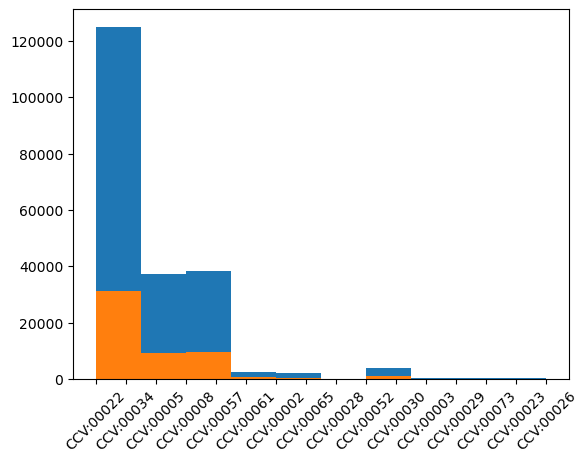

In [4]:
# Load data
X = np.load('Data/data.npz', allow_pickle=True)['X']
y = np.load('Data/data.npz', allow_pickle=True)['y']
if VERBOSE:
    logger.info('Data loaded')


# Split data (training/hold-out set)
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
if VERBOSE:
    logger.info('Hold-out set is obtained')


# Class visualization
import matplotlib.pyplot as plt
plt.hist(trainY);
plt.hist(testY);
plt.xticks(rotation=45);


# Label encoding for targe class
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)
pickle.dump(le, open('label_encoder.sav', 'wb'))
# Get classes/labels
labels = list(le.classes_)
if VERBOSE:
    logger.info('Label encoding of target variable is performed')

# Hyperparameter optimization

In [5]:
# Initiate mlflow server
# Command: mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 127.0.0.1 --port 5000
# 
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("UC:TU|Model:XGBoost")

if VERBOSE:
    logger.info('MLFlow server is connected')

## Prediction model

In [6]:
def objective(trial: optuna.trial.Trial) -> float: 
    # Logger
    if VERBOSE:
        logger.info(f'Trail: {trial.number} started [{trial.datetime_start}]')

    # Parameters
    params = {
        'n_estimators'      : trial.suggest_categorical('n_estimators', [300, 500]),
        'learning_rate'     : trial.suggest_categorical('learning_rate' , [1e-2, 5e-2, 1e-1]),
        'max_depth'         : trial.suggest_int('max_depth', 3, 6),
        'reg_alpha'         : 20, #trial.suggest_categorical('reg_alpha', [10, 20, 30]),
        'reg_lambda'        : 1.0, #trial.suggest_loguniform('reg_lambda', 0, 1),
        'gamma'             : 1, #trial.suggest_loguniform('gamma', 1 , 9),
        'min_child_weight'  : 2, #trial.suggest_int('min_child_weight', 2, 4),
        'max_leaves'        : 2, #trial.suggest_int('max_leaves', 2, 5),
    }


    # Setup model
    model = xgboost.XGBClassifier(objective           = 'multi:softmax',  
                                  n_jobs              = -1,                                   
                                  validate_parameters = True, 
                                  verbosity           = 1,
                                  tree_method         = 'hist',
                                  **params)
    
    # Cross-Validation
    # train_CV_results, test_CV_results, CM_cv = cross_validation(model=model, X=trainX, Y=trainY, n_splits=n_splits, seed=seed, VERBOSE=VERBOSE)
    train_CV_results, test_CV_results,  CM_cv = None, None, None
    # Single-run 
    model, train_results, test_results, CM, predictions = single_run(model=model, trainX=trainX, trainY=trainY, testX=testX, testY=testY, VERBOSE=VERBOSE)

         
    if VERBOSE:
        logger.info(f'Trail: {trial.number} completed')

    # Include model signature
    signature = mlflow.models.infer_signature(testX, predictions)
    # Log performance to MLflow 
    MLflow_log_performance(trial.number, model, labels,
                           train_CV_results, test_CV_results, CM_cv, 
                           train_results, test_results, CM,
                           signature, params)

    # Copy artifacts
    copyDirTree('./artifacts', '../artifacts')
    
    if VERBOSE:
        logger.info(f'Trail: {trial.number} Performance metrics & model logged')

    # return np.mean(test_CV_results['AUC'])
    return np.mean(test_results['AUC'])    

## Hyperparameter optimization process

In [7]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed = seed),
                           )

study.optimize(func=objective, 
               n_trials=n_trials, 
               n_jobs=1,)

[I 2023-05-05 00:00:24,914] A new study created in memory with name: no-name-22584ebf-2264-4bee-9f1b-df363dbdcba8


[0]	validation_0-auc:0.72824	validation_1-auc:0.72749
[50]	validation_0-auc:0.78476	validation_1-auc:0.78436
[100]	validation_0-auc:0.79942	validation_1-auc:0.79867
[150]	validation_0-auc:0.80659	validation_1-auc:0.80568
[200]	validation_0-auc:0.81161	validation_1-auc:0.81060
[250]	validation_0-auc:0.81670	validation_1-auc:0.81563
[300]	validation_0-auc:0.82085	validation_1-auc:0.81980
[350]	validation_0-auc:0.82448	validation_1-auc:0.82342
[400]	validation_0-auc:0.82715	validation_1-auc:0.82605
[450]	validation_0-auc:0.82912	validation_1-auc:0.82801
[499]	validation_0-auc:0.83103	validation_1-auc:0.82984


[W 2023-05-05 00:17:35,103] Trial 0 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 3} because of the following error: TypeError("'NoneType' object is not subscriptable").
Traceback (most recent call last):
  File "c:\Users\ioann\anaconda3\envs\ML\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ioann\AppData\Local\Temp\ipykernel_2888\244818878.py", line 51, in objective
    return np.mean(test_CV_results['AUC'])
TypeError: 'NoneType' object is not subscriptable
[W 2023-05-05 00:17:35,105] Trial 0 failed with value None.


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Delete temp directory
import shutil
shutil.rmtree('Performance')
shutil.rmtree('artifacts')

### Visualization of the learning curves of the trials


In [ ]:
optuna.visualization.plot_optimization_history(study)

### Visualization of hyperparameter relationships


In [ ]:
optuna.visualization.plot_parallel_coordinate(study, params=[params for params in study.best_params])

### Hyperparameter importances


In [ ]:
optuna.visualization.plot_param_importances(study, 
                                            target      = lambda t: t.duration.total_seconds(), 
                                            target_name = "duration")

### Get optimized hyperparameters

In [ ]:
print('[INFO] Optimized hyperparameters\n')
for (parameter,value) in study.best_params.items():
    if ( isinstance(value, float) ):
        print(' >%25s: %.3f' % (parameter,value))
    else:
        print(' >%25s: %s' % (parameter,value))